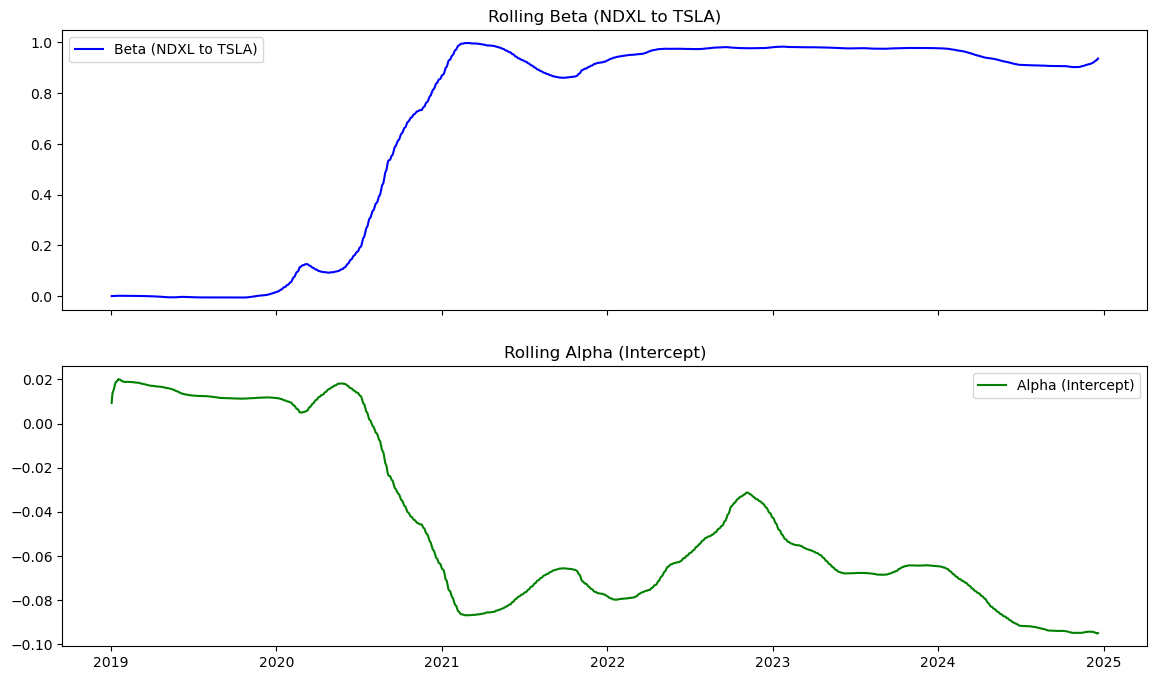

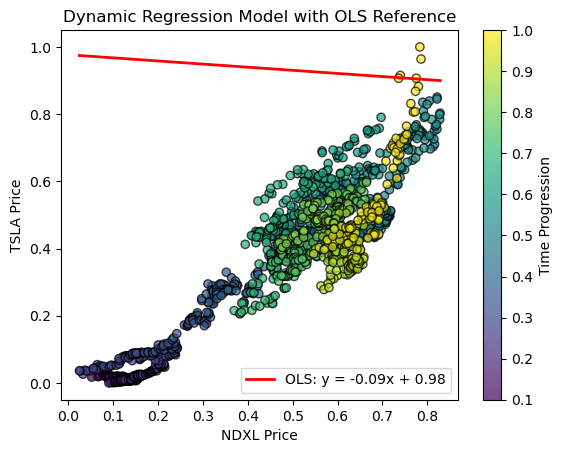

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from numpy.polynomial.polynomial import Polynomial

# Load data and ensure proper datetime parsing with timezone awareness
tsla_data = pd.read_csv('/Users/jivenchana/Documents/TSLA-Model-v1.6/DataCsv/TSLA_Normalised_OHLC_VWAP_VOL.csv')
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'], utc=True)
tsla_data.set_index('Date', inplace=True)

ndxl_data = pd.read_csv('/Users/jivenchana/Documents/TSLA-Model-v1.6/DataCsv/NDXL_Normalised_OHLC_VWAP_VOL.csv')
ndxl_data['Date'] = pd.to_datetime(ndxl_data['Date'], utc=True)
ndxl_data.set_index('Date', inplace=True)

# Filter data to include only observations from 2021 to 2024
start_date = pd.Timestamp('2019-01-01', tz='UTC')
end_date = pd.Timestamp('2024-12-31', tz='UTC')
tsla_data = tsla_data.loc[start_date:end_date]
ndxl_data = ndxl_data.loc[start_date:end_date]

# Ensure both datasets are aligned by date
data = pd.concat([tsla_data['Close_Price'], ndxl_data['Close_Price']], axis=1).dropna()
data.columns = ['TSLA_Price', 'NDXL_Price']

# Observation matrix using prices directly
obs_mat = np.vstack([data['NDXL_Price'], np.ones(len(data['NDXL_Price']))]).T

# Initialize Kalman Filter
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance
kf = KalmanFilter(
    n_dim_obs=1,    # y is 1-dimensional (TSLA price)
    n_dim_state=2,  # state is 2-dimensional (beta and alpha)
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat[:, np.newaxis],
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

# Manually update the filter for each time point
n_timesteps = len(data)
means = np.zeros((n_timesteps, 2))
covariances = np.zeros((n_timesteps, 2, 2))

for i in range(n_timesteps):
    if i == 0:
        means[i], covariances[i] = kf.filter_update(kf.initial_state_mean,
            kf.initial_state_covariance,
            observation=data['TSLA_Price'].iloc[i],
            observation_matrix=obs_mat[i, np.newaxis]
        )
    else:
        means[i], covariances[i] = kf.filter_update(
            means[i-1],
            covariances[i-1],
            observation=data['TSLA_Price'].iloc[i],
            observation_matrix=obs_mat[i, np.newaxis]
        )

# Plotting Beta and Alpha over time
_, axarr = plt.subplots(2, sharex=True, figsize=(14, 8))
axarr[0].plot(data.index, means[:, 0], label='Beta (NDXL to TSLA)', color='blue')
axarr[0].set_title('Rolling Beta (NDXL to TSLA)')
axarr[0].legend()
axarr[1].plot(data.index, means[:, 1], label='Alpha (Intercept)', color='green')
axarr[1].set_title('Rolling Alpha (Intercept)')
axarr[1].legend()

# OLS Regression Line for the entire dataset
ols_coef = np.polyfit(data['NDXL_Price'], data['TSLA_Price'], 1)
ols_line = Polynomial(ols_coef)
xi = np.linspace(data['NDXL_Price'].min(), data['NDXL_Price'].max(), 100)
plt.figure()
plt.scatter(data['NDXL_Price'], data['TSLA_Price'], c=np.linspace(0.1, 1, len(data)), cmap='viridis', edgecolor='k', alpha=0.7)
plt.plot(xi, ols_line(xi), color='red', lw=2, label=f'OLS: y = {ols_coef[1]:.2f}x + {ols_coef[0]:.2f}')
plt.colorbar(label='Time Progression')
plt.title('Dynamic Regression Model with OLS Reference')
plt.xlabel('NDXL Price')
plt.ylabel('TSLA Price')
plt.legend()
plt.show()

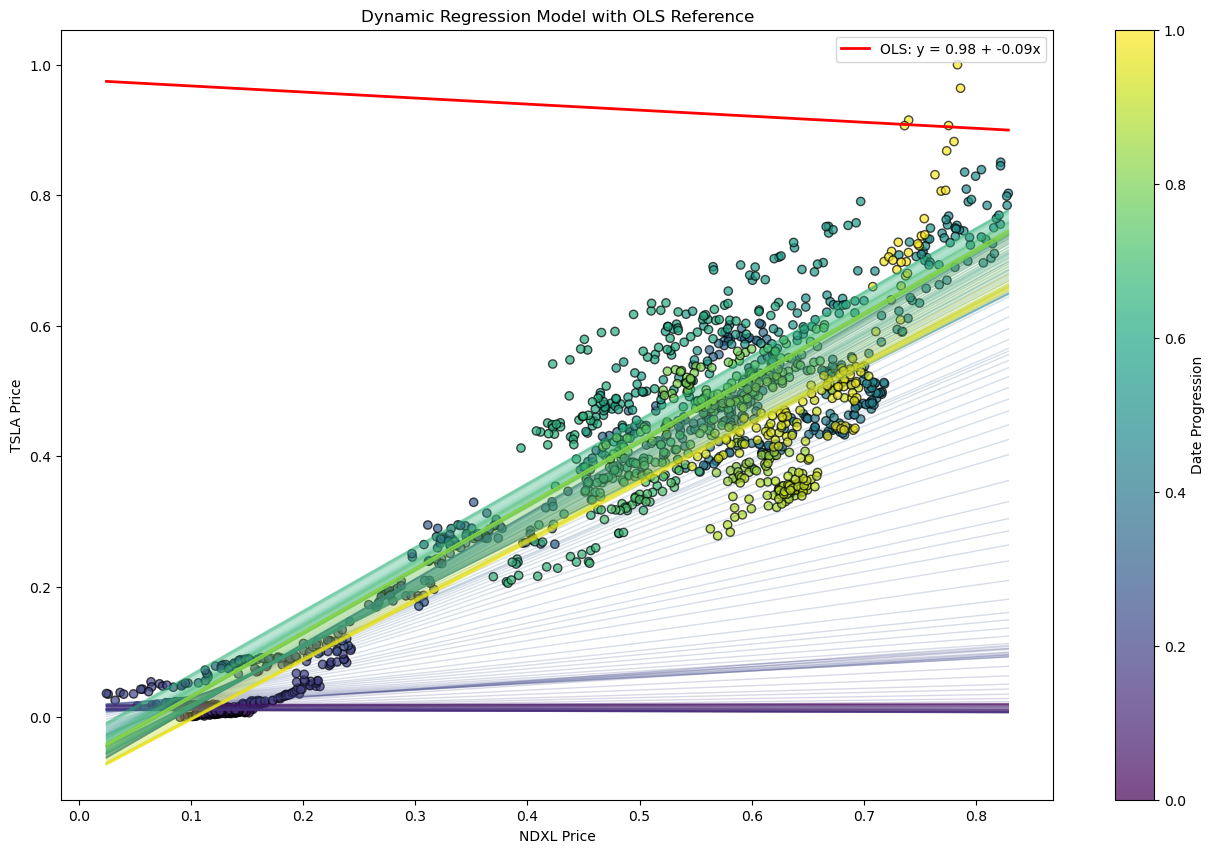

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from numpy.polynomial.polynomial import Polynomial

# Load data and ensure proper datetime parsing with timezone awareness
tsla_data = pd.read_csv('/Users/jivenchana/Documents/TSLA-Model-v1.6/DataCsv/TSLA_Normalised_OHLC_VWAP_VOL.csv')
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'], utc=True)
tsla_data.set_index('Date', inplace=True)

ndxl_data = pd.read_csv('/Users/jivenchana/Documents/TSLA-Model-v1.6/DataCsv/NDXL_Normalised_OHLC_VWAP_VOL.csv')
ndxl_data['Date'] = pd.to_datetime(ndxl_data['Date'], utc=True)
ndxl_data.set_index('Date', inplace=True)

# Filter data to include only observations from 2019 to 2024
start_date = pd.Timestamp('2019-01-01', tz='UTC')
end_date = pd.Timestamp('2024-12-31', tz='UTC')
tsla_data = tsla_data.loc[start_date:end_date]
ndxl_data = ndxl_data.loc[start_date:end_date]

# Ensure both datasets are aligned by date
data = pd.concat([tsla_data['Close_Price'], ndxl_data['Close_Price']], axis=1).dropna()
data.columns = ['TSLA_Price', 'NDXL_Price']

# Observation matrix using prices directly
obs_mat = np.vstack([data['NDXL_Price'], np.ones(len(data['NDXL_Price']))]).T

# Initialize Kalman Filter
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance
kf = KalmanFilter(
    n_dim_obs=1,    # y is 1-dimensional (TSLA price)
    n_dim_state=2,  # state is 2-dimensional (beta and alpha)
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat[:, np.newaxis],
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

# Manually update the filter for each time point
n_timesteps = len(data)
means = np.zeros((n_timesteps, 2))
covariances = np.zeros((n_timesteps, 2, 2))

for i in range(n_timesteps):
    if i == 0:  
        means[i], covariances[i] = kf.filter_update(kf.initial_state_mean,
            kf.initial_state_covariance,
            observation=data['TSLA_Price'].iloc[i],
            observation_matrix=obs_mat[i, np.newaxis]
        )
    else:
        means[i], covariances[i] = kf.filter_update(
            means[i-1],
            covariances[i-1],
            observation=data['TSLA_Price'].iloc[i],
            observation_matrix=obs_mat[i, np.newaxis]
        )

# Setting up the plot with a larger figure size
plt.figure(figsize=(16, 10))  # Adjust figure size here
cm = plt.get_cmap('viridis')
colors = np.linspace(0, 1, len(data))
sc = plt.scatter(data['NDXL_Price'], data['TSLA_Price'], c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.set_label('Date Progression')

# Plot Kalman filter regression lines with colormap
xi = np.linspace(data['NDXL_Price'].min(), data['NDXL_Price'].max(), 100)
for i in range(0, n_timesteps, 5):
    plt.plot(xi, means[i, 0] * xi + means[i, 1], alpha=0.2, lw=1, color=cm(colors[i]))

# OLS Regression Line for the entire dataset
ols_coef = np.polyfit(data['NDXL_Price'], data['TSLA_Price'], 1)
ols_line = Polynomial(ols_coef)
plt.plot(xi, ols_line(xi), color='red', lw=2, label=f'OLS: y = {ols_coef[0]:.2f} + {ols_coef[1]:.2f}x')

plt.title('Dynamic Regression Model with OLS Reference')
plt.xlabel('NDXL Price')
plt.ylabel('TSLA Price')
plt.legend()
plt.show()